 #   Open Data Project Presentation CODE1161 
 Name: Zhang Wang  (z5248079)

Topic: Crash Data in Queensland, Australia

# Introduction
   Background: "Damage Cost Analysis" is a method of conducting economic analysis on the damages caused by accidents, disasters, or other events. This analysis aims to estimate the losses incurred by the event, including direct economic losses, indirect economic impacts, and other related costs. The purpose of this analysis is to help decision-makers understand the potential consequences of the event, providing a basis for policy-making, taking actions, or making investment decisions.
   
   Data source: Downloaded from the Queensland Government Open Data Portal(https://www.data.qld.gov.au/dataset/crash-data-from-queensland-roads)
   
   Data content: Crashes in Queensland from 2001 to 2021, including latitude and longitude information, vehicle information, date of occurrence information and relevant road environment information
   
   Purpose of analyzing data: It is hoped that the correlation between car accidents and other factors can be drawn from these data to reduce the occurrence of car accidents

# Analysis Topics 
As stated above, the goal of this open data project is to analyze the relationship between the various data of the accident, I will analyze my data from these sections,including:

    1. The location of the crash
    2. Date and severity of the crash
    3. The correlation between the severity of crashes and other data

 Lets start by importing the appropriate files

In [1]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
from scipy.stats import chi2_contingency
from shapely.geometry import Point, Polygon, MultiPolygon
from matplotlib.colors import ListedColormap
file_name = "C:\\Users\\oliver\\1161\\dateproject\\date\\crashdate.csv"

In [2]:
%matplotlib inline

Extract and get crash data from my path

In [3]:
penalty_data = pd.read_csv('C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv')
penalty_data.head(3)

,Crash_Ref_Number,Crash_Severity,Crash_Day_Of_Week,Crash_Longitude,Crash_Latitude,Crash_Speed_Limit,Crash_Lighting_Condition,Count_Casualty_Fatality,Count_Casualty_Hospitalised,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
0,1,Hospitalisation,Monday,153.052207,-27.586357,0 - 50 km/h,Daylight,0,1,0,0,1,1,0,0,0,1,0,0
1,2,Property damage only,Wednesday,153.064920,-27.595907,60 km/h,Daylight,0,0,0,0,0,2,0,0,0,0,0,0
2,3,Minor injury,Thursday,153.058445,-27.599409,60 km/h,Daylight,0,0,0,1,1,2,0,0,0,0,0,0


# The location of the crash


Latitude and longitude data were used to map the location of each accident, with a map of Queensland as the background

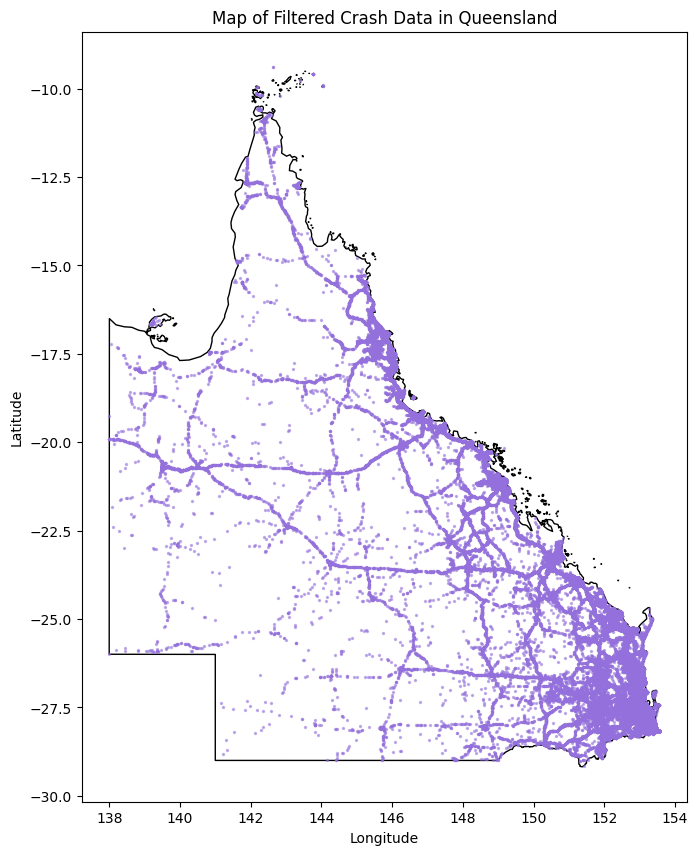

In [4]:
# Define valid ranges for longitude and latitude
valid_longitude_range = (130, 160)
valid_latitude_range = (-30, 0)
filtered_data = penalty_data[
    (penalty_data['Crash_Longitude'] >= valid_longitude_range[0]) &
    (penalty_data['Crash_Longitude'] <= valid_longitude_range[1]) &
    (penalty_data['Crash_Latitude'] >= valid_latitude_range[0]) &
    (penalty_data['Crash_Latitude'] <= valid_latitude_range[1])
]
queensland = gp.read_file(
    'C:\\Users\\oliver\\1161\\dateproject\\date\\queensland.json'
)
filtered_points = gp.GeoDataFrame(geometry=gp.points_from_xy(
    filtered_data['Crash_Longitude'], filtered_data['Crash_Latitude']
))
fig, axs = plt.subplots(figsize=(20, 10))
queensland.boundary.plot(ax=axs, color='black', linewidth=1)  # Plot Queensland boundary
filtered_points.plot(ax=axs, marker='o', markersize=2,
                     alpha=0.5, color='mediumpurple', zorder=2)  # Plot filtered data points
axs.set_title('Map of Filtered Crash Data in Queensland')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
# Display the plot
plt.show()


According to the distribution map of car accident locations, I found that most of the car accidents occurred in the southeast of Queensland, where there were some scenic spots and residential areas, including the Gold Coast and other famous scenic spots. Therefore, there was a large traffic flow, and more car accidents would occur


But this range is too large to analyze other factors in car crashes, so I use the boundaries of Queensland's boroughs to break it down

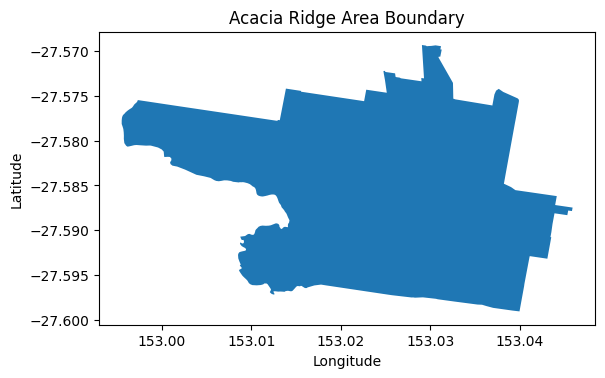

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,lcp1538f231f6a1,locb9e60560b913,2021-06-24,Abbeywood,Gazetted Locality,QLD,"POLYGON ((151.638 -26.146, 151.637 -26.146, 15..."
1,lcp5c0cb0eb8528,locda24ebdbfa94,2021-06-24,Abbotsford,Gazetted Locality,QLD,"POLYGON ((152.004 -24.883, 151.999 -24.879, 15..."
2,lcp1f44628e7c62,loc58529273d380,2021-06-24,Abercorn,Gazetted Locality,QLD,"POLYGON ((151.136 -25.178, 151.135 -25.177, 15..."


In [5]:
# Load the geospatial data for localities from the specified shapefile
burbs = gp.GeoDataFrame.from_file(
    'C:\\Users\\oliver\\1161\\dateproject\\date\\GDA2020\\qld_localities.shp'
)

# Set the Coordinate Reference System (CRS) for the geospatial data
# This ensures that the spatial information is interpreted correctly
# The specified EPSG code (5234) represents GDA2020
burbs.set_crs(epsg=5234, inplace=True, allow_override=True)

# Select the locality data for Acacia Ridge from the loaded geospatial data
gold_coast = burbs[burbs['LOC_NAME'].str.contains('Acacia Ridge', case=False)]

# Plot the selected Acacia Ridge area boundary
gold_coast.plot()

# Set the plot title and labels for the x and y axes
plt.title('Acacia Ridge Area Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

# Display the first 3 rows of the loaded geospatial data (localities)
burbs.head(3)


In [6]:
# Define a function that calculates the centroid of a geometry
def add_centroid(row):
    return row.geometry.centroid

# Apply the "add_centroid" function to each row in the GeoDataFrame "burbs"
# along the specified axis (axis=1 indicates applying the function to rows)
# The result is stored in a new column called "centroid"
burbs["centroid"] = burbs.apply(add_centroid, axis=1)

# Sample two random rows from the GeoDataFrame "burbs"
# This provides a glimpse of the data after adding the "centroid" column
burbs.sample(2)


,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,centroid
1004,lcp2d3b3ccd5f4f,loc8711b0e2e4ed,2021-06-24,Euleilah,Gazetted Locality,QLD,"POLYGON ((151.866 -24.548, 151.866 -24.548, 15...",POINT (151.85925 -24.49375)
2727,lcp1664e45f9437,loceae5aae02f47,2021-06-24,Sunrise Beach,Gazetted Locality,QLD,"POLYGON ((153.105 -26.426, 153.105 -26.426, 15...",POINT (153.10280 -26.41659)


<Axes: >

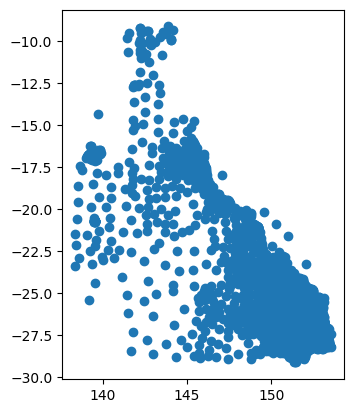

In [7]:
# Plot the centroids of the localities in the GeoDataFrame "burbs"
burbs.centroid.plot()


POINT (152.01080397169943 -24.830328047524123)


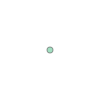

In [8]:
# Extract the geometry (locality polygon) of the second row from the GeoDataFrame "burbs"
a = burbs.iloc[1]

# Calculate and print the centroid of the extracted geometry (locality polygon)
print(a.centroid)

# Plot the extracted geometry (locality polygon) centroid on the map
a.centroid



Text(0.5, 1.0, 'Distribution of distances from The selected center point')

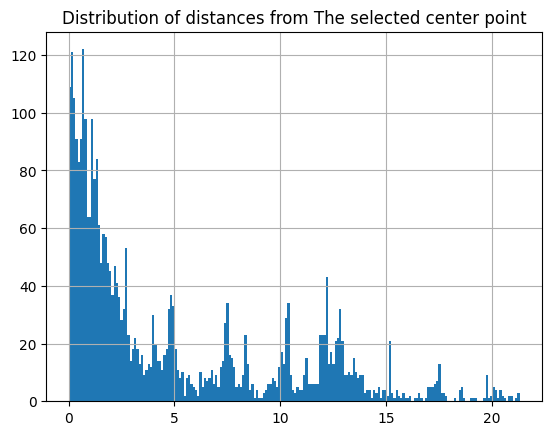

In [9]:
# Create a Shapely Point object representing the coordinates of a location
right_here = shapely.geometry.point.Point(153.0587653330788, -27.478362304023605)

# Calculate the distance from each locality centroid to the specified location (right_here)
# The calculated distances are stored in a new column named "distance_from_UNSW"
burbs["distance_from_The_selected_center_point"] = burbs.centroid.distance(right_here)

# Plot a histogram of the distribution of distances from UNSW for all localities
# The "bins" parameter specifies the number of bins in the histogram
burbs.distance_from_The_selected_center_point.hist(bins=200)

# Set the title for the histogram plot
plt.title("Distribution of distances from The selected center point")


<Axes: >

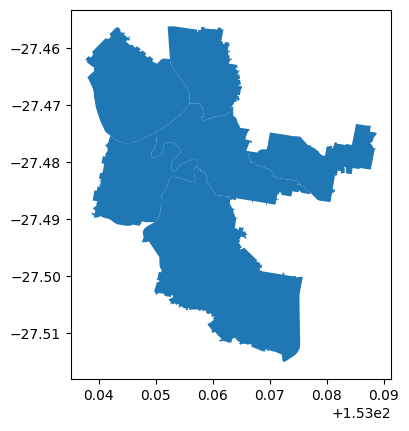

In [10]:
# Select localities from the GeoDataFrame "burbs" that are within a certain distance (less than 0.03) from UNSW
close_burbs = burbs[burbs.distance_from_The_selected_center_point < 0.022]

# Plot the selected localities on the map
close_burbs.plot()


In [11]:
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
for point in points:
    pass

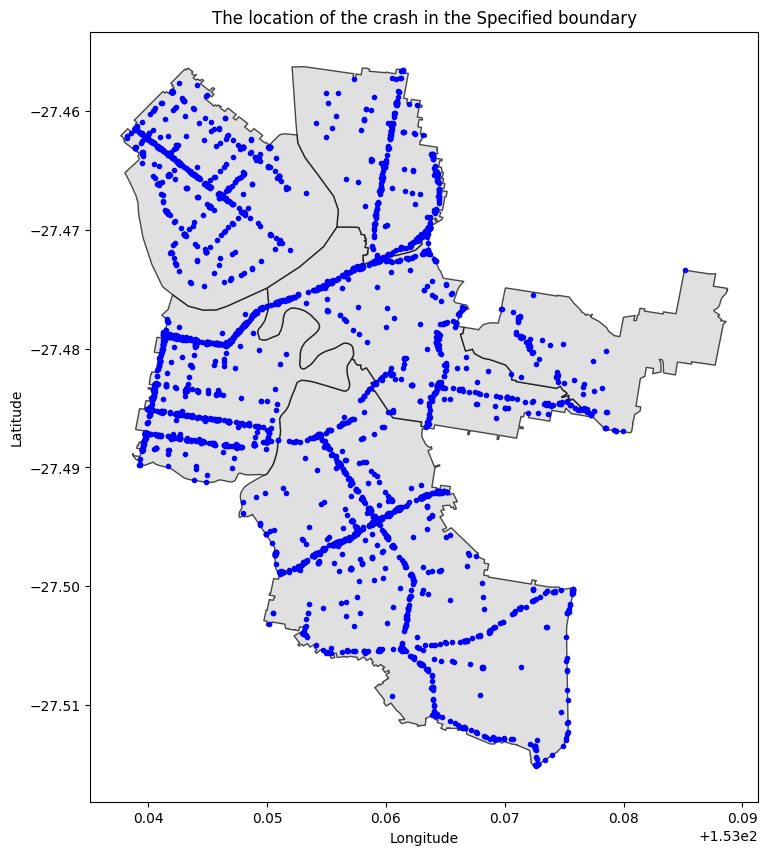

In [12]:
# Create a list of points from the latitude and longitude columns in the penalty_data DataFrame
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
for point in points:
    pass
points = list(zip(penalty_data['Crash_Longitude'], penalty_data['Crash_Latitude']))
for point in points:
    pass
polygon_column = 'geometry'
polygons = close_burbs[polygon_column]
polygonslist = [Polygon(coords) for coords in polygons]
multi_polygon = MultiPolygon(polygonslist)
# Find the points that are inside the MultiPolygon
points_inside_polygons = [
    point for point in points if multi_polygon.contains(Point(point))
]
# Create a plot to visualize the points inside the polygons
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the close_burbs GeoDataFrame as a background
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)
# Plot the points inside the polygons in blue
for point in points_inside_polygons:
    plt.plot(point[0], point[1], 'bo', markersize=3)
# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Display the plot
plt.show()



This is what I got, located in the southeast, where there's more data on car crashes, which is good for analysis

Next, I use the day of week and Crash Severity data from the crash data to color the points of these crashes

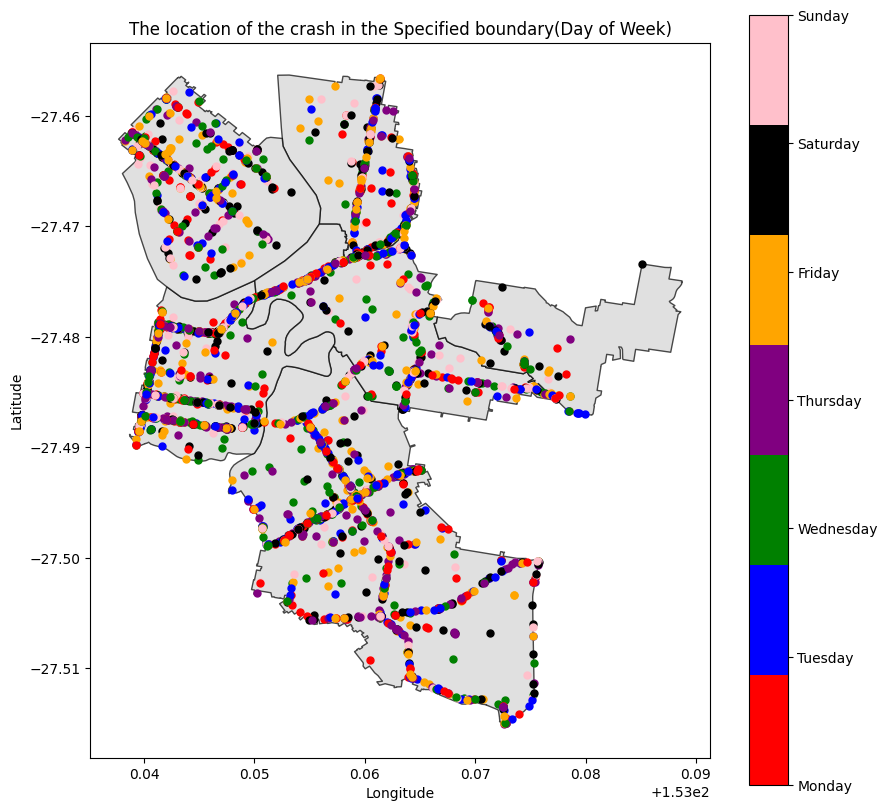

In [13]:
# Extract the 'Crash_Day_Of_Week' column as labels for crash days of the week
crash_day_of_week_labels = penalty_data['Crash_Day_Of_Week']
day_of_week_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
crash_day_of_week_numeric = [day_of_week_mapping[label] for label in crash_day_of_week_labels]
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'pink']
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=0, vmax=len(day_of_week_mapping) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
polygon_column = 'geometry'
polygons = close_burbs[polygon_column]
polygonslist = [Polygon(coords) for coords in polygons]
multi_polygon = MultiPolygon(polygonslist)
points_inside_polygons = [
    (point, day) for point, day in zip(points, crash_day_of_week_numeric) if multi_polygon.contains(Point(point))
]
fig, ax = plt.subplots(figsize=(10, 10))
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)
for point, day in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(day), markersize=5)
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(day_of_week_mapping)))
cbar.set_ticklabels(day_of_week_mapping.keys())
# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary(Day of Week)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Display the plot
plt.show()


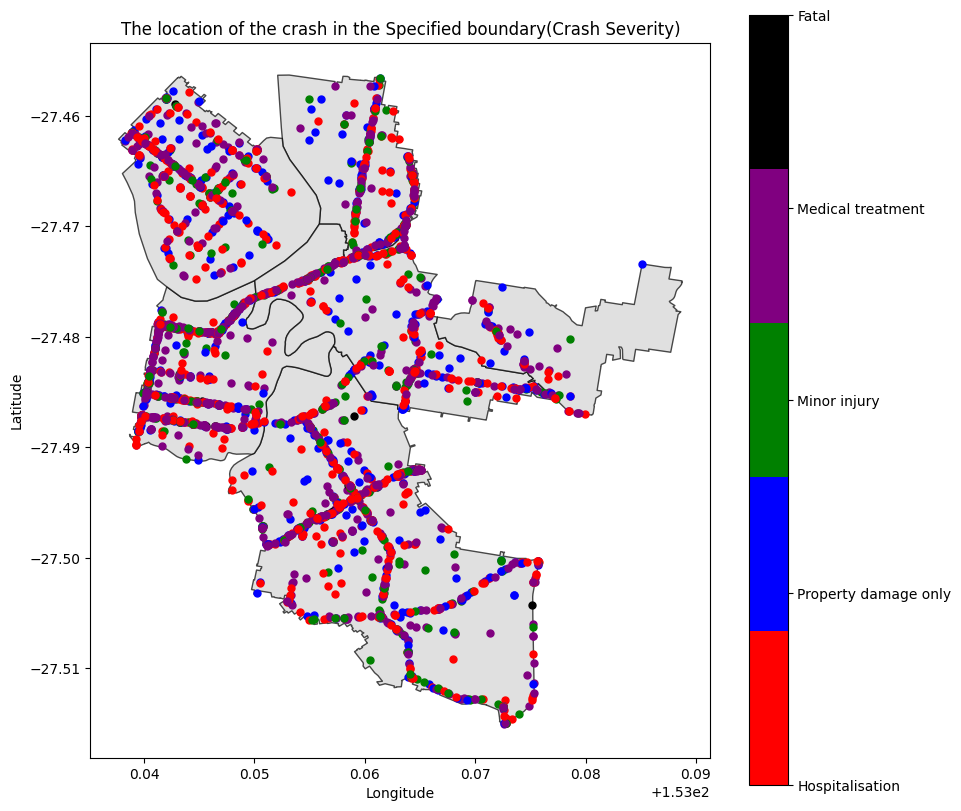

In [14]:
# Extract the 'Crash_Severity' column as labels for crash severity levels
crash_severity_labels = penalty_data['Crash_Severity']
severity_labels = ['Hospitalisation', 'Property damage only', 'Minor injury', 'Medical treatment', 'Fatal']
severity_mapping = {label: index for index, label in enumerate(severity_labels)}
crash_severity_numeric = [severity_mapping[label] for label in crash_severity_labels]
colors = ['red', 'blue', 'green', 'purple', 'black']
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=0, vmax=len(severity_labels) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
polygon_column = 'geometry'
polygons = close_burbs[polygon_column]
polygonslist = [Polygon(coords) for coords in polygons]
multi_polygon = MultiPolygon(polygonslist)
points_inside_polygons = [
    (point, severity) for point, severity in zip(points, crash_severity_numeric) if multi_polygon.contains(Point(point))
]
fig, ax = plt.subplots(figsize=(10, 10))
close_burbs.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.7)
for point, severity in points_inside_polygons:
    plt.plot(point[0], point[1], 'o', color=sm.to_rgba(severity), markersize=5)
cbar = plt.colorbar(sm, ax=ax, ticks=range(len(severity_labels)))
cbar.set_ticklabels(severity_labels)
# Set plot attributes
ax.set_title('The location of the crash in the Specified boundary(Crash Severity)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Display the plot
plt.show()


Looking at the two distribution maps, it appears that more crashes occur on Fridays, and more crashes result in Hospitalisation and Medical treatment in terms of the consequences of the crashes. But this conclusion is not accurate enough, so I decided to draw a histogram of it

# Date and severity of the crash

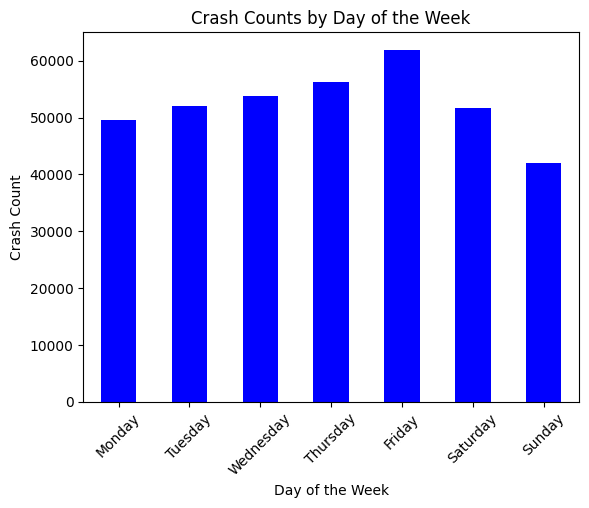

In [15]:
# Define the file path to the CSV file containing the data
file_path = 'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv'
# Read the data from the CSV file into a DataFrame
data = pd.read_csv(file_path)
# Convert the "Crash_Day_Of_Week" column to uppercase to ensure consistent casing
data["Crash_Day_Of_Week"] = data["Crash_Day_Of_Week"].str.upper()
# Define a mapping from day names to day numbers
day_mapping = {
    "MONDAY": 1,
    "TUESDAY": 2,
    "WEDNESDAY": 3,
    "THURSDAY": 4,
    "FRIDAY": 5,
    "SATURDAY": 6,
    "SUNDAY": 7
}
# Map day names to day numbers and create a new column "Day_Number" in the DataFrame
data["Day_Number"] = data["Crash_Day_Of_Week"].map(day_mapping)
# Group the data by "Day_Number" and count occurrences for each day
day_counts = data.groupby("Day_Number").size()
# Reindex the day counts to ensure all days of the week are included, even if no data exists for a particular day
day_counts = day_counts.reindex([1, 2, 3, 4, 5, 6, 7], fill_value=0)
# Plot a bar chart to visualize the data counts for each day of the week
day_counts.plot(kind="bar", color="blue")
# Set the x-axis tick labels to display the day names
plt.xticks(range(7), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)
# Set the title, x-axis label, and y-axis label for the plot
plt.title("Crash Counts by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Crash Count")
# Display the plot
plt.show()


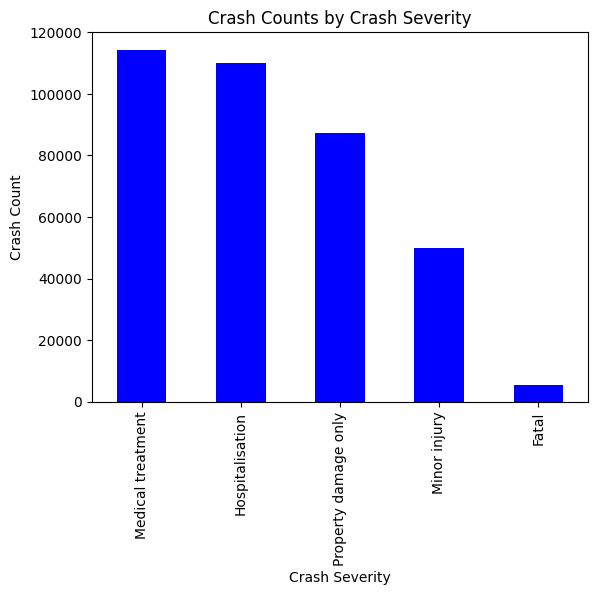

In [25]:
# Define the file path to the CSV file containing the data
file_path = 'C:\\Users\\oliver\\1161\\dateproject\\crashdate.csv'
# Read the data from the CSV file into a DataFrame
data = pd.read_csv(file_path)
# Define a list of crash severity values to filter the data
severity_values = ['Hospitalisation', 'Property damage only', 'Minor injury', 'Medical treatment', 'Fatal']
# Filter the data to include only rows with crash severity values in the defined list
filtered_data = data[data["Crash_Severity"].isin(severity_values)]
# Count the occurrences of each unique crash severity value in the filtered data
severity_counts = filtered_data["Crash_Severity"].value_counts()
# Plot a bar chart to visualize the data counts for each crash severity value
severity_counts.plot(kind='bar', color='blue')
# Set the title, x-axis label, and y-axis label for the plot
plt.title("Crash Counts by Crash Severity")
plt.xlabel("Crash Severity")
plt.ylabel("Crash Count")
# Display the plot
plt.show()


Judging from the two bar charts, my previous analysis is correct, but I did not consider that Friday is the time when the most traffic accidents occur. I think it may be related to people's reduced travel on weekends and busy working from Monday to Thursday

# The correlation between the severity of crashes and other data
Next, I was curious about the relationship between the severity of the accident and other factors (such as road light, road speed limit, and time of day).

So I created a correlation heat map to show the relationship between these factors

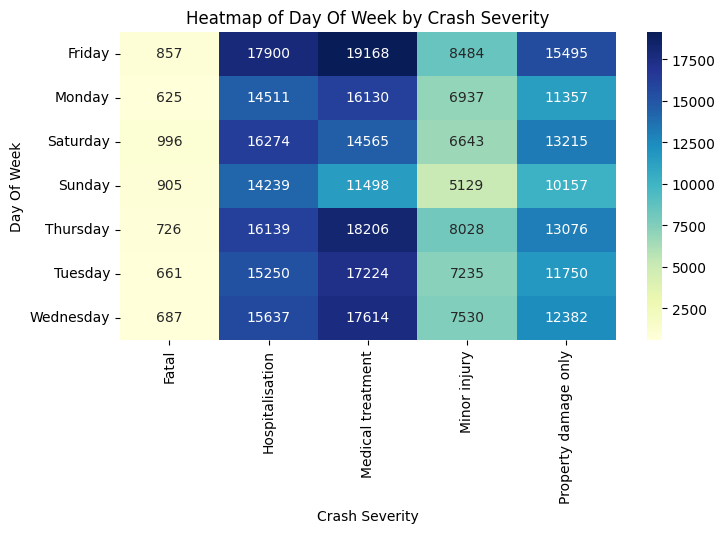

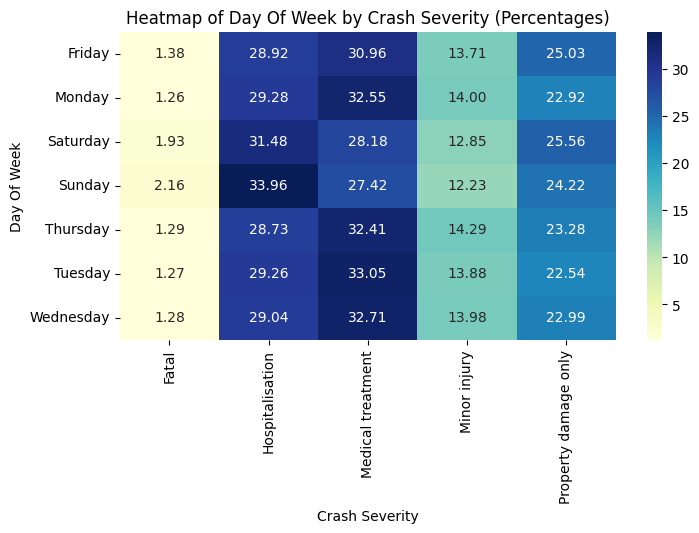

In [23]:
cross_tab = pd.crosstab(data["Crash_Day_Of_Week"], data["Crash_Severity"])
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Heatmap of Day Of Week by Crash Severity")
plt.xlabel("Crash Severity")
plt.ylabel("Day Of Week")
plt.show()
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab_percent, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Heatmap of Day Of Week by Crash Severity (Percentages)")
plt.xlabel("Crash Severity")
plt.ylabel("Day Of Week")
plt.show()

First I made a heat map of the correlation between the Crash Severity and the Day Of Week

The chart uses specific numbers at the beginning, but I don't think it accurately reflects the correlation between these two factors, so I should plot it as a percentage. Obviously, we can get that there is a higher probability of serious car accidents on weekends, while midweek car accidents are more likely to have less serious consequences

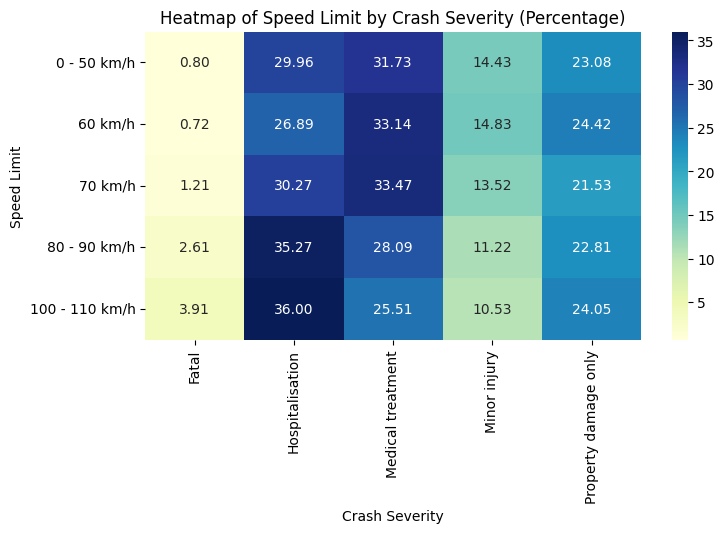

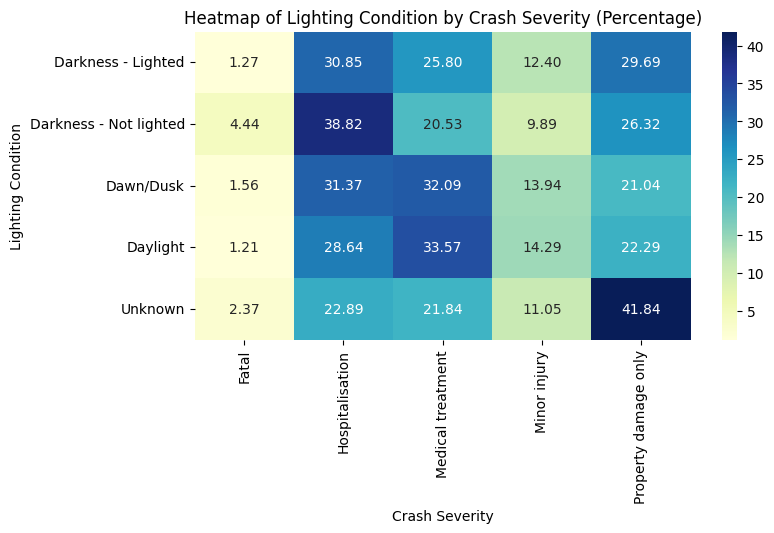

In [24]:
from sklearn.preprocessing import LabelEncoder
speed_limit_order = ["0 - 50 km/h", "60 km/h", "70 km/h", "80 - 90 km/h", "100 - 110 km/h"]
cross_tab = pd.crosstab(data["Crash_Speed_Limit"], data["Crash_Severity"])
cross_tab_reordered = cross_tab.reindex(speed_limit_order)
cross_tab_percentage = cross_tab_reordered.div(cross_tab_reordered.sum(axis=1), axis=0) * 100
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab_percentage, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Heatmap of Speed Limit by Crash Severity (Percentage)")
plt.xlabel("Crash Severity")
plt.ylabel("Speed Limit")
plt.show()
cross_tab = pd.crosstab(data["Crash_Lighting_Condition"], data["Crash_Severity"])
cross_tab_percentage = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
plt.figure(figsize=(8,4))
sns.heatmap(cross_tab_percentage, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Heatmap of Lighting Condition by Crash Severity (Percentage)")
plt.xlabel("Crash Severity")
plt.ylabel("Lighting Condition")
plt.show()

Next, I drew a heat map of the correlation between road factors and the consequences of a car accident

As the chart shows, more serious accidents are more likely to occur on highways and dark and unlit roads, while low speed limits and daytime are less likely to cause serious accidents

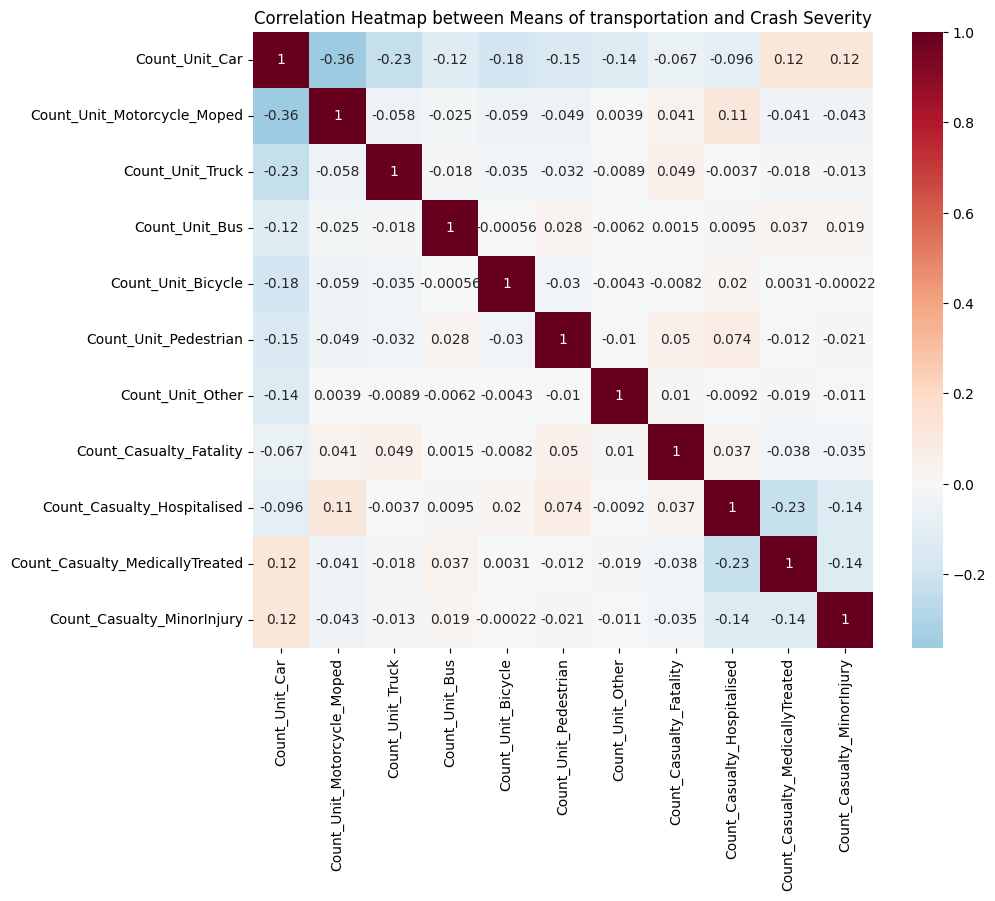

In [20]:
columns_of_interest = [
    "Count_Unit_Car", "Count_Unit_Motorcycle_Moped", "Count_Unit_Truck",
    "Count_Unit_Bus", "Count_Unit_Bicycle", "Count_Unit_Pedestrian",
    "Count_Unit_Other",
    "Count_Casualty_Fatality", "Count_Casualty_Hospitalised",
    "Count_Casualty_MedicallyTreated", "Count_Casualty_MinorInjury"
]
subset_data = data[columns_of_interest]
correlation_matrix = subset_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdBu_r", center=0)
plt.title("Correlation Heatmap between Means of transportation and Crash Severity")
plt.show()

Then I made a heat map of the correlation between vehicle types and the consequences of car accidents. 

From the correlation chart, it can be seen that motorcycles and trucks are very unsafe and more likely to cause serious consequences, while buses and riding are safer

# Conclusion
There are many factors affecting car accidents. We need to collect observation and analysis data more deeply, and use these analysis results to improve our laws and regulations and urban infrastructure, so as to reduce the occurrence of accidents. As individuals, we should also keep a low speed when traveling, and minimize driving vehicles with high risk. And try to drive in a place with a good view to ensure our own safety

# Thank You!